In [1]:
import skimage.io as io
import pandas as pd
import os
import subprocess
import warnings
warnings.filterwarnings("ignore")  # skimage warns when saving uint16 with not covering full range of 0-65535
example_root = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'examples')

# Train Detectron2 model with PCNA data

__Author: Yifan Gui @ Kuan Yoow Chan group__

__WARNING__: to run the tutorial, make sure you have downloaded pre-trained maskRCNN model [here]()

pcnaDeep relies on __maskRCNN__ backbone from Facebook's __Detectron2__ fremework to segment the fluroscent/brightfield image and predict cell cycle stage of each segmentated object. During mitosis entry, after nucleus envelope breakdown, PCNA signal flees from the nucleus into the cytoplasm, leaving itself as dim as the background.  
To fix the problem, pcnaDeep take advantages of the bright field image (DIC/phase contrast) on which mitosis cells have clear boundaries when they round up. The predictor can faithfully tell cycle cycle phase as long as __fluroscent and birght field images are fed to the model simutaneously__.

## Standard training & annotation data format
The __training image data__ is in the same format as prediction input, i.e., intensity-rescaled __3-channel `.png`__.  

The three channels are `[PCNA, PCNA, brightfield]`.

The __training annotation data__ adpots the __`.json`__ format of __VGG Image Annotator__, in which points delineating the contour of a region, plus the region label (cell cycle phase) are recorded. 

_How to convert your DIC/phase constrast + PCNA images to standard image format?_ See [getting_started](./getting_started.ipynb)

In this tutorial We will use a 5-frame toy data chosen from a 24hr time-lapse RPE1 imaging dataset.

In [2]:
stack = io.imread(os.path.join(example_root, 'RPE', 'stack.tif'))
stack.shape

(5, 1200, 1200, 3)

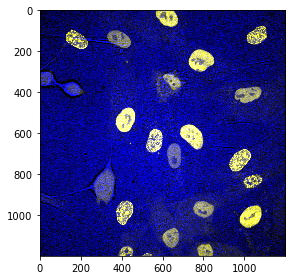

In [3]:
io.imshow(stack[1,:,:])  # check out 2 mitosis cells on this frame :)

---
## 1. Annotate training data
### 1.1a Acquire mask & classification from model prediction (recommended)
It is suggested to begin annotation from pretrained model __`.json`__ output, which is compatible with and can be imported to __VGG Image Annotator 2 (VIA2)__.

__`run_seg_cls.py`__ is a handy script to do the job. It takes in similar paramters as `main.py`, but not those for tracking and cell cycle profiling. Moreover, `run_seg_cls.py` directly outputs `.json` file.

In [3]:
# Generate command
config_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'config', 'pcna_res50.yaml')
input_path = os.path.join(example_root, 'RPE', 'stack.tif')
output_path = os.path.join(example_root, 'RPE')
model_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'model', 'dtrn_20210303.pth')
paths = list(map(lambda x:"\""+x+"\" ", [config_path, input_path, output_path, model_path]))
command = 'python run_seg_cls.py --config-file ' + paths[0] + '--input ' + paths[1] + '--output ' + paths[2] + '--json_out ' + '--opts MODEL.WEIGHTS ' + paths[3]
command

'python run_seg_cls.py --config-file "/Users/jefft/Desktop/Chan lab/SRTP/ImageAnalysis/PCNAdeep/config/pcna_res50.yaml" --input "/Users/jefft/Desktop/Chan lab/SRTP/ImageAnalysis/PCNAdeep/examples/RPE/stack.tif" --output "/Users/jefft/Desktop/Chan lab/SRTP/ImageAnalysis/PCNAdeep/examples/RPE" --json_out --opts MODEL.WEIGHTS "/Users/jefft/Desktop/Chan lab/SRTP/ImageAnalysis/PCNAdeep/model/dtrn_20210303.pth" '

_Note:_ You can always __run through commandline (recommended)__. `--json_out` tells the machine to output `.json` file, otherwise standard detectron2 visualisation image (raw superimposed with object detectron) will be output, which requires `opencv` installation.

In [ ]:
# run detection
cmd = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)
cmd.communicate()

### 1.1b Acquire mask from conventional segmentation (for _de novo_ labeling)
Another approach is to generate mask from conventional segmentation methods, i.e., thresholding. Common processing pipeline includes Gaussian-filtering, thresholding, open-calculation, gap-filling, small partical-removing. __Fiji software__ can efficiently do this on batch. Below is a reference __macro__ performing segmentation on PCNA channel _ONLY_. 

`
run("Gaussian Blur...", "sigma=2");
setAutoThreshold("Default dark");
setOption("BlackBackground", false);
run("Convert to Mask");
run("Open");
run("Fill Holes");
run("Analyze Particles...", "size=1000-Infinity show=Masks");
run("Adjustable Watershed", "tolerance=4");
run("Invert LUT");
`

_Note:_ __Output must be saved in `.png` format.__

_Note:_ [`Adjustable Watershed`](https://imagejdocu.tudor.lu/plugin/segmentation/adjustable_watershed/start) is an optional plugin, because fiji build-in watershed sometimes oversegments the mask.

_Note:_ In this way, no cell cycle classification can be _automatically_ labeled, and another round of conversion is required to generate VIA2-readable `.json` file.

To generate `.json` from mask, __`pcnaDeep.data.utils.mask2json( )`__ scans masks from the input directory and records all contours of a mask in a `.json` file. The mask file name in this file is kept the same as original one. Although the function can interpret cell cycle phase from labeled mask through the default mapping `{10:"G1/G2", 50:"S", 100:"M", 200:'E'}` when method parameter `phase_labeled=True`, it is not recommended to label them from this step. `mask2json( )` sets the default classification as `'G1/G2'`.

In [4]:
from pcnaDeep.data.utils import mask2json
mask2json(in_dir = os.path.join(example_root, 'RPE', 'Fiji_mask'), 
          out_dir = os.path.join(example_root, 'RPE', 'Fiji_mask'),
          phase_labeled = False,
         prefix = 'stack')

The code generates file `RPE_stack.json` that is readable by VIA2.

### 1.2 Save raw image stack as `.png` slices.
VIA2 can only read `.png` images, therefore, we must convert raw image stack to this through __`pcnaDeep.data.annotate.save_seq( )`__.

__REMINDER:__ Both pcnaDeep detectron2 model and `pcnaDeep.data.annotate.mask2json( )` outputs `.json` with file name following the following rule, which must be considered when calling `save_seq( )`:

|prefix|-|000x (frame)|format|
|---|---|---|---|
|stack|-|0001|.png|


In [3]:
from pcnaDeep.data.annotate import save_seq
save_seq(stack, os.path.join(example_root, 'RPE', 'frames'), 
        prefix='stack-', dtype='uint16', dig_num=4, base=1, img_format='.png', keep_chn=True)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


Our stack has three channels; whether to label on brightfield + PCNA channel or only PCNA channel depends on personal choice. Some may find composite image easier to label mitosis, some (especially experienced ones) may think single channel is tidier. 

Switch whether to save three channels or the first one (PCNA) using `keep_chn` parameter. 

### 1.3 Correct classification and classification through VIA2 software

Open VIA2 software, default path of the image folder should be set through __Settings > Default Path__. (only once for annotating one dataset) In our case, it will be '\<PATH TO PROJECT ROOT\>/pcnaDeep/examples/RPE/frames/'. Press __Save__ at the bottom of settings. Import `.json` annotation file through __Annotations > Import Annotations (from json)__. You should see the following interface. If no, check path setting and the matching between file name in json file and the raw data.

![demo](assets/via2_1.png)

Following [VIA2 instructions](https://www.robots.ox.ac.uk/~vgg/software/via/) to get familiar with the tool. You may find toggle labeling (keyboard: space), remove region (keyboard: d) useful.

---
#### To correct cell boundaries and classifications, here are specific __guidelines__:
1. Cells should be labeled as __G1/G2, S, M, or E__. 
   - __G1/G2__ means the region is either G1 or G2. Although PCNA expression level is high in G2 and low in G1, we do not expect the model to identify this due to the variability of the illumination conditions.
   - __E__ means 'emergine' from the mitosis, where the nuclear envelope has already formed, but signal intensity between the nucleus and the cytoplasm is similar.
   - __M__ as mitosis, defined from nuclear envelope break down to the reformation of nuclear envelope. Mitosis cells can be clearly discerned from brightfield image as they round up.
   - __S__ phase is characterized by granule-like distribution of PCNA protein in the nucleus. When there are more than 3 foci, the nucleus can be classificed as S.
   
   &emsp;Here are some examples of each class.
   
   ![demo](assets/cls_demo.png)
   
   __(1)__ Typical label of __G1/G2__ and __S__ phase cells  
   __(2)__ An example of __unlabeled mitosis cell__ (in red). After drawing cell boundary, need to specify cell cycle phase.  
   __(3)__ Two typical __mitosis cells__. The upper left has already passed cytokinesis while the lower left has just passed nuclear envelope breakdown. Note the upper left contains an overlapped detection which should be erased. 3a and 3b are comparsions between PCNA-only channel and PCNA/brightfield composite.  
   __(4)__ The synchrogram of a __complete mitosis process__ (cell referred is labeled with a triangle and arbitrary track shown as dashed line). Note the slight __difference between E and G1/G2__. E has more cytoplasm background compared with typical G1/G2. However, because E and G1/G2 will be assigned with G1/G2 during cell cycle resolving, such labeling does not need to be very precise, as long as it facilitates the machine to learn.
   
   
2. If unsure about cell cycle phase, check raw time-lapse with temporal information.


3. Boundary labeling does not need to be extremely precise; typically 20 points is enough to delineate a nucleus of MCF10A/RPE1 cells under 60X.


4. Label as much as you can, if you cannot discern, neither the computer.


5. Sometimes the model outputs overlapped regions which should be deleted, be careful to them

---
To save current progress, use __Project > Save__ to save the VIA2 project. Next time you may directly open the project without configuring the image path through __Project > Load__.

Once all the labeling is finished, use __Annotations > Export Annotations (as json)__ to get standard `.json` file used in pcnaDeep.

---
## 2. Organize data path and config model training set

Once you have your input images and annotation `.json` file. Organize them in an informative way. 

E.g.

|----MCF10A_s1

&emsp;|---MCF10A_s1-0001.jpg  
&emsp;|---MCF10A_s1-0002.jpg

|----MCF10A_s1.json

According to the repository, config the training script `train_detectron2.py` from line 224:

(line 224) `DATASET_ROOT = [MCF10A_s1]`

(line 225) `TRAIN_ANN_PATH = [MCF10A_s1.json]`

The model `pcnaDeep.data.preparePCNA` will resolve these inputs to feed into detectron2 model.

---

`train_detectron2.py` is a __plain training schedule modified from Detectron2 offical demo__, which training from maskRCNN model baseline. To train from pcnaDeep pretrained model, change the following config:

(line 153) `cfg.merge_from_file("../config/pcna_res50.yaml")`

(line 157) `cfg.MODEL.WEIGHTS = "../model/dtrn_20210303.pth"`

_Note:_ You can always specify detectron2 configurations from commandline by `--opts`, or modify `.yaml` directly.

_None:_ Other configurations, including iteration time, learning rate, augmentation etc. are shown in function `setup( )` Plase check [Detectron2 config references](https://detectron2.readthedocs.io/en/latest/modules/config.html?highlight=config#config-references) for details.

---
## 3. Train model

Run `train_detectron2.py` from the commandline:

`python train_detectron2.py --num-gpus 1`